### MGSC 695 - Optimization for Data Science

#### Winter 2024, Dr.Sanjith Gopalakrishnan

### Assignment 2

#### Submitted by Jared Balakrishnan (McGill ID #261175926)

In [104]:
from pathlib import Path 
import gurobipy as gb
from gurobipy import *
import pandas as pd 
import numpy as np

In [105]:
dataset_path = Path().absolute() / "datasets"

def read_dataset(file_path: Path) -> pd.DataFrame:

    """Function to read in a dataframe from a given filepath."""

    return pd.read_csv(file_path)

In [106]:
advertising_df = read_dataset(dataset_path / "advertising.csv")

In [107]:
advertising_df.head(5)

,Unnamed: 0,TV,Radio,Newspaper,Sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


For a linear regression model, the L1 loss function can be written as:

$$
 y_i - (\beta_0 + \beta_1 x_{i1} + \ldots + \beta_p x_{ip}) 
 $$

Choosing parameters such that the sum of absolute errors is minimized, ie minimizing the L1 loss function can therefore be written as:

$$
\text{minimize} \sum_{i=1}^{n} \left| y_i - (\beta_0 + \beta_1 x_{i1} + \ldots + \beta_p x_{ip}) \right|
$$

The L1 loss function can be expressed as: 

$$
\left| y_i - (\beta_0 + \beta_1 x_{i1} + \ldots + \beta_p x_{ip}) \right| = \text{max} \{ y_i - (\beta_0 + \beta_1 x_{i1} + \ldots + \beta_p x_{ip}), (\beta_0 + \beta_1 x_{i1} + \ldots + \beta_p x_{ip}) - y_i \}
$$

Let's say $y_i - (\beta_0 + \beta_1 x_{i1} + \ldots + \beta_p x_{ip}) = w$

We can therefore write:

$$
 w \geq \text{max} \{ y_i - (\beta_0 + \beta_1 x_{i1} + \ldots + \beta_p x_{ip}), (\beta_0 + \beta_1 x_{i1} + \ldots + \beta_p x_{ip}) - y_i \}
 $$

 $$
 w \geq y_i - (\beta_0 + \beta_1 x_{i1} + \ldots + \beta_p x_{ip})
 $$

  $$
 w \geq (\beta_0 + \beta_1 x_{i1} + \ldots + \beta_p x_{ip}) - y_i
 $$

 Therefore we can formulate the linear program as being:
 
 $$
 \text{min}(w) \\
 \text{such that } w \geq y_i - (\beta_0 + \beta_1 x_{i1} + \ldots + \beta_p x_{ip}) \\
 w \geq (\beta_0 + \beta_1 x_{i1} + \ldots + \beta_p x_{ip}) - y_i
 $$

 Considering the dataset we are working with seems to be dealing with advertising, it's hard to imagine negative amounts of money being spent on any advertising medium, because of which we can also write a non-negativity constraint as follows:

 $$
 x_{ip} \geq 0 \\
 i = 1, 2, \cdots, n \\
 p = 1, 2, 3
 $$

## Formulating an LP Model in Gurobi

In [108]:
# Initializing an LP Model in Gurobi
linearRegModel = gb.Model("Linear Regression Model (L1 Loss Function)")

In [109]:
# Initializing Decision Variables
Beta = linearRegModel.addVars(4, vtype = GRB.CONTINUOUS, name = [f"Beta_{i}" for i in range(4)])
W = linearRegModel.addVars(len(advertising_df), lb = 0, vtype = GRB.CONTINUOUS)

In [110]:
# Initializing the expression for the objective function
sum_exp = gb.quicksum(W[i] for i in range(len(advertising_df)))
linearRegModel.setObjective(sum_exp, GRB.MINIMIZE)

In [112]:
# Setting up the constraints
for index, row in advertising_df.iterrows():

    linearRegModel.addConstr(W[index] >= row['Sales'] - (Beta[0] + Beta[1]*row['TV'] + Beta[2]*row['Radio'] + Beta[3]*row['Newspaper']), name = "Absolute Value - Positive")
    linearRegModel.addConstr(W[index] >= -row['Sales'] + (Beta[0] + Beta[1]*row['TV'] + Beta[2]*row['Radio'] + Beta[3]*row['Newspaper']), name = "Absolute Value - Negative")

    

In [113]:
linearRegModel.optimize()

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 400 rows, 204 columns and 1998 nonzeros
Model fingerprint: 0x983d2b74
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 3e+01]
Presolve time: 0.00s
Presolved: 400 rows, 204 columns, 1998 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.497438e+02   0.000000e+00      0s
     245    2.4251181e+02   0.000000e+00   0.000000e+00      0s

Solved in 245 iterations and 0.01 seconds (0.01 work units)
Optimal objective  2.425118112e+02


In [128]:
print("Parameter Estimations by using the L1 Loss Function using Gurobi:")

for v in linearRegModel.getVars():
    
    if v.varName[0] == "B":
        print(v.varName, v.x)

Parameter Estimations by using the L1 Loss Function using Gurobi:
Beta_0 3.2797893774713356
Beta_1 0.04382140799173407
Beta_2 0.1967413118206927
Beta_3 0.0


## Comparison of Parameter Estimates to a Linear Regression model with an L2 Loss Function

|    |   L1 Loss Function |   L2 Loss Function |        delta |
|---:|-----------------:|--------------------------:|-------------:|
|  0 |       3.279    |                2.93889    | 0.34011 |
|  1 |       0.0438  |                0.0457646  | -0.0019646 |
|  2 |       0.1967    |                0.18853    | 0.00817 |
|  3 |      0.00 |               -0.00103749 |  -0.00103749 |


Please note Coefficient/Parameter 0 refers to the intercept!

## Problem 2: INCOMPLETE

In [121]:
from sklearn.datasets import make_blobs
from matplotlib import pyplot as plt

In [122]:
# Using make_blobs to generate 500 observations
# Two predictors (as indicated by n_features = 2) and one outcome variable
# y stores the integer labels of the observations
X, y = make_blobs(n_samples = 500, n_features = 2, centers = 2, random_state= 42)

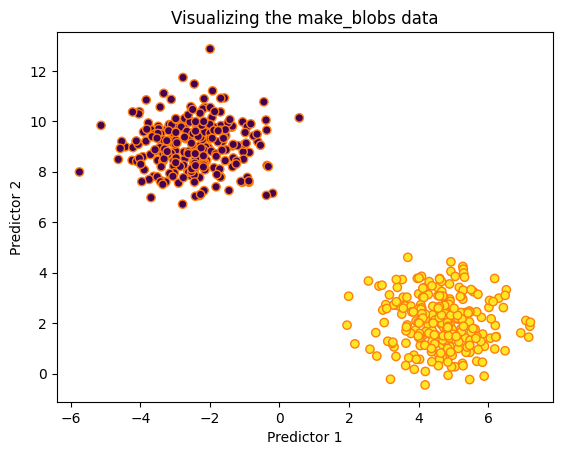

In [130]:
# Creating a scatterplot to visualize the relationship between the observations
plt.scatter(X[:, 0], X[:, 1], c = y, edgecolors = "#ff7f0e")
plt.xlabel('Predictor 1')
plt.ylabel('Predictor 2')
plt.title('Visualizing the make_blobs data')
plt.show()

### Implementing a Linear Classifier in Gurobi

In [251]:
linearClassifier = gb.Model("Linear Classifier Implementation in Gurobi")

In [252]:
y_transformed = 2 * y - 1

In [253]:
# Initializing the decision variables

alpha = linearClassifier.addVars(2, vtype = GRB.CONTINUOUS, lb = -GRB.INFINITY, ub = GRB.INFINITY, name = [f"weight {i}" for i in range(2)])
bias = linearClassifier.addVar(vtype = GRB.CONTINUOUS, ub = GRB.INFINITY, name = "bias term")

In [254]:
slack = linearClassifier.addVars(len(y_transformed), lb=0, name="slack")
C = 1  # This is the penalty parameter, which you may need to tune for your problem
linearClassifier.setObjective(0.5 * (alpha[0]*alpha[0] + alpha[1]*alpha[1]) + C * gb.quicksum(slack[i] for i in range(len(y_transformed))), GRB.MINIMIZE)


In [255]:
# setting up the constraints

for i in range(len(y_transformed)):

    linearClassifier.addConstr(y_transformed[i] * (alpha[0] * X[i, 0] + alpha[1] * X[i, 1] + bias) >= 1 - slack[i])

In [256]:
linearClassifier.optimize()

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 500 rows, 503 columns and 2000 nonzeros
Model fingerprint: 0x9bc805fc
Model has 2 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-02, 1e+01]
  Objective range  [1e+00, 1e+00]
  QObjective range [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 500 rows, 503 columns, 2000 nonzeros
Presolved model has 2 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 2
 AA' NZ     : 1.248e+05
 Factor NZ  : 1.252e+05 (roughly 1 MB of memory)
 Factor Ops : 4.179e+07 (less than 1 second per iteration)
 Threads    : 10

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   5.48124999e+06 -6.07493659e-11  0.00e+00 9.15e-06  

In [257]:
alpha_1 = alpha[0].X

In [258]:
alpha_2 = alpha[1].X

In [259]:
beta_val = bias.x

In [260]:
linearClassifier.ObjVal

0.10173077579213052

In [261]:
print(alpha_1, alpha_2, beta_val)

0.28734142697070625 -0.34770167658235673 1.540930291917951


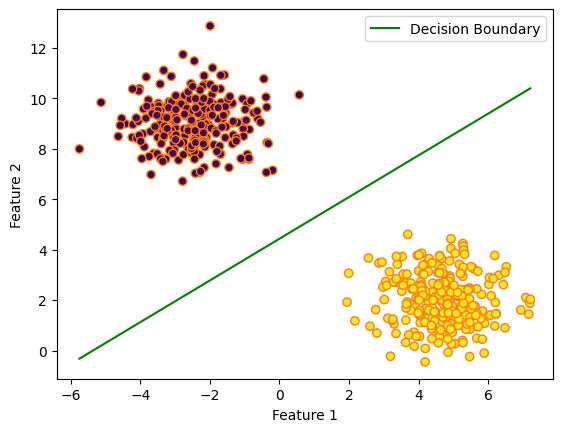

In [262]:
plt.scatter(X[:, 0], X[:, 1], c = y, edgecolors = "#ff7f0e")
x0 = np.linspace(X[:, 0].min(), X[:, 0].max(), 200)
x1 = (-1 * (beta_val + (alpha_1 * x0)))/(alpha_2)

plt.plot(x0, x1, color = 'green', label = 'Decision Boundary')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()